In [1]:
import numpy as np # 数値計算ライブラリ
import matplotlib.pyplot as plt # グラフ描画ライブラリ
import scienceplots # グラフ描画テーマ

In [2]:
def ekf(f, h, A, B, C, Q, R, y, x_hat, P):
    """EKF
    
    Args:
        f (function): 非線形関数
        h (function): 非線形関数
        A (function): fのヤコビアン
        B (np.ndarray): システム行列
        C (function): hのヤコビアン
        Q (np.ndarray): システム雑音の共分散行列
        R (np.ndarray): 観測雑音の共分散行列
        y (np.ndarray): 観測値
        x_hat (np.ndarray): 事前状態推定値
        P (np.ndarray): 事前誤差共分散行列

    Returns:
        tuple: 事後状態推定値, 事後誤差共分散行列, カルマンゲイン
    """
    x_hat_neg = f(x_hat) # 事前状態推定値
    P_neg = A(x_hat) @ P @ A(x_hat).T + B @ Q @ B.T # 事前誤差共分散行列
    # G = P_neg @ C(x_hat_neg).T @ np.linalg.inv(C(x_hat_neg) @ P_neg @ C(x_hat_neg).T + R) # カルマンゲイン
    G = P_neg @ C(x_hat_neg).T / (C(x_hat_neg) @ P_neg @ C(x_hat_neg).T + R) # カルマンゲイン
    x_hat_new = x_hat_neg + G @ (y - h(x_hat_neg)) # 事後状態推定値
    P_new = (np.eye(len(x_hat)) - G @ C(x_hat_neg)) @ P_neg # 事後誤差共分散行列

    return (x_hat_new, P_new, G)

In [3]:
def u_trans(f, xm, Pxx):
    """Unscented transform
    
    Args:
        f (function): 非線形関数
        xm (np.array): 平均値
        Pxx (np.array): 共分散行列

    Returns:
        ym (np.array): 平均値
        Pyy (np.array): 共分散行列
        Pxy (np.array): 共分散行列
    """
    dim = len(xm) # 次元数
    kappa = 3 - dim # パラメータ
    w0 = kappa / (dim + kappa) # 重み
    wi = 1 / (2 * (dim + kappa)) # 重み
    W = np.diag([w0] + [wi] * dim * 2) # 重み行列

    L = np.linalg.cholesky(Pxx) # シグマポイントの計算に使用
    X = np.vstack([
        x_neg.T, 
        np.ones([dim, 1]) * xm.T + np.sqrt(dim + kappa) * L,
        np.ones([dim, 1]) * xm.T - np.sqrt(dim + kappa) * L
    ]) # シグマポイントの計算
    
    Y = np.matrix(f(np.array(X.T)).T) # 非線形関数の適用

    ym = sum(W * Y).T # 期待値の計算

    Yd = Y - np.ones(Y.shape) * ym.T # 平均値の除算
    Xd = X - np.ones(X.shape) * xm.T # 平均値の除算
    Pyy = Yd.T * W * Yd # 共分散行列の計算
    Pxy = Xd.T * W * Yd # 共分散行列の計算

    return ym, Pyy, Pxy

In [4]:
def ukf(f, h, B, Q, R, y, x_hat, P):
    """UKF

    Args:
        f (function): 非線形関数
        h (function): 非線形関数
        B (np.ndarray): システム行列
        Q (np.ndarray): システム雑音の共分散行列
        R (np.ndarray): 観測雑音の共分散行列
        y (np.ndarray): 観測値
        x_hat (np.ndarray): 事前状態推定値
        P (np.ndarray): 事前誤差共分散行列

    Returns:
        tuple: 事後状態推定値, 事後誤差共分散行列, カルマンゲイン
    """
    x_hat_neg, P_neg, _ = u_trans(f, x_hat, P) # U変換による遷移後状態の近似
    P_neg = P_neg + B @ Q @ B.T # システム雑音を加える
    y_hat_neg, Pyy, Pxy = u_trans(h, x_hat_neg, P_neg) # U変換による出力値の近似 

    # G = Pxy @ np.linalg.inv(Pyy + R) # カルマンゲイン
    G = Pxy / (Pyy + R) # カルマンゲイン

    x_hat_new = x_hat_neg + G @ (y - y_hat_neg) # 事後状態推定値
    P_new = P_neg - G @ Pxy.T # 事後誤差共分散行列

    return (x_hat_new, P_new, G)

<Figure size 2000x1600 with 0 Axes>

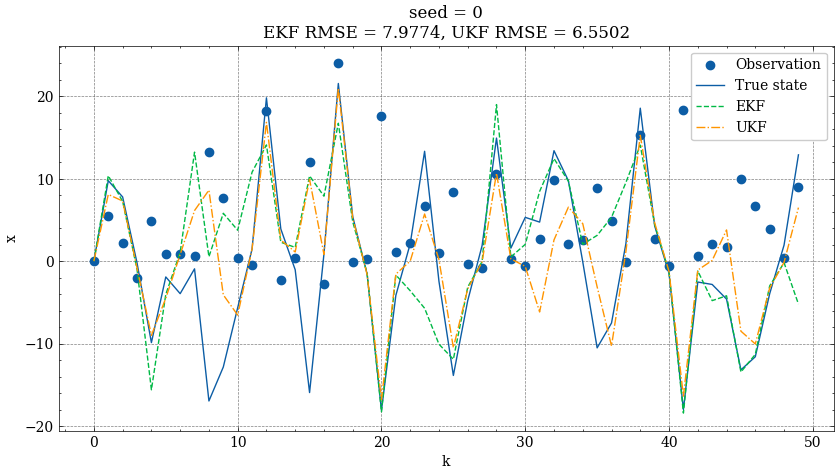

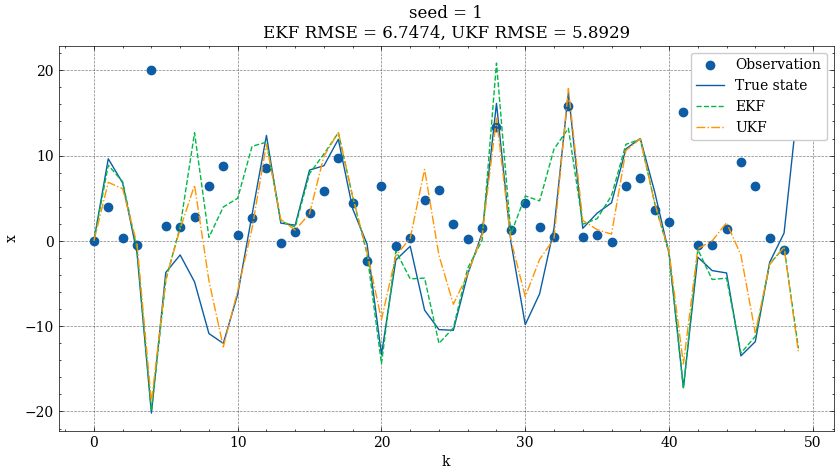

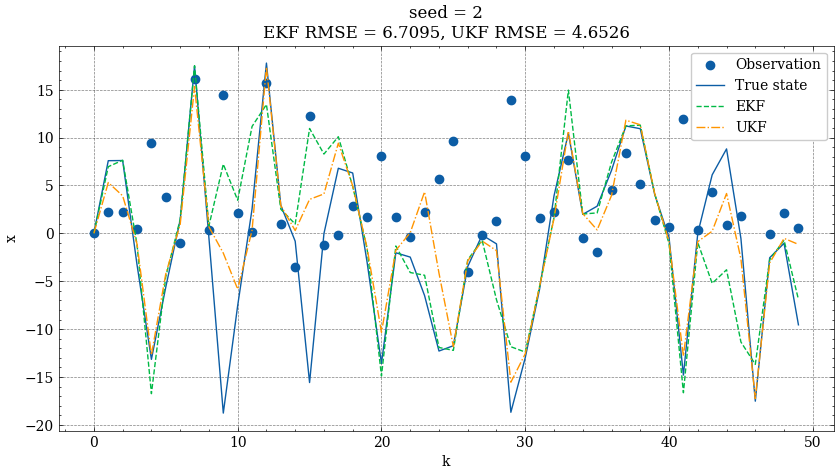

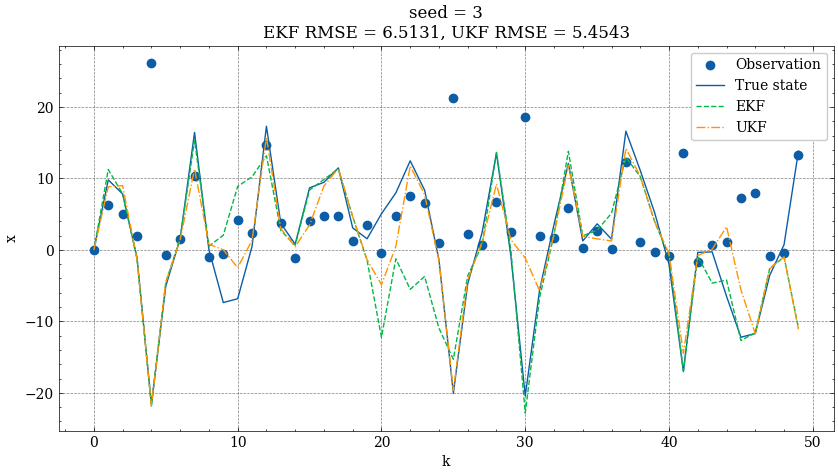

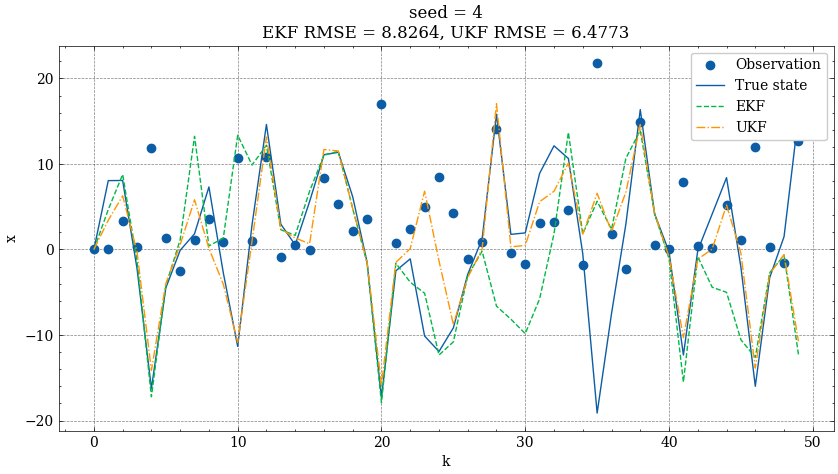

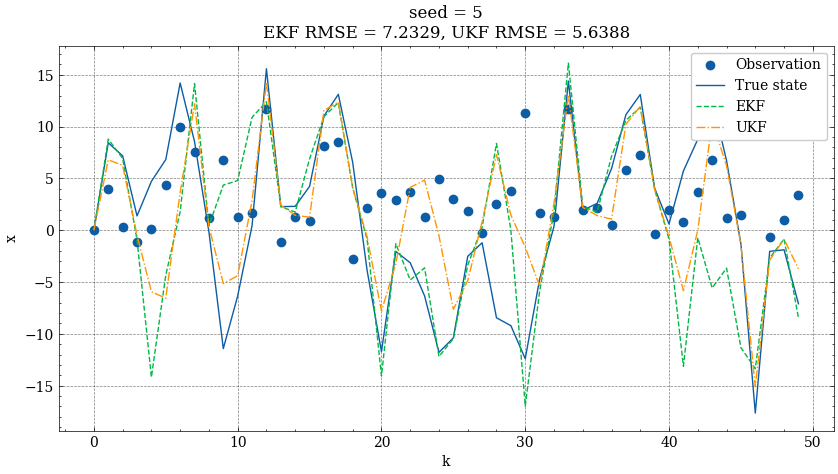

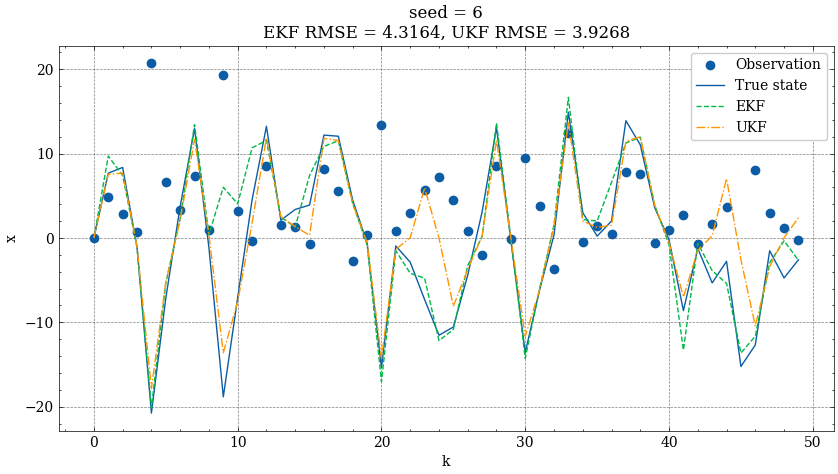

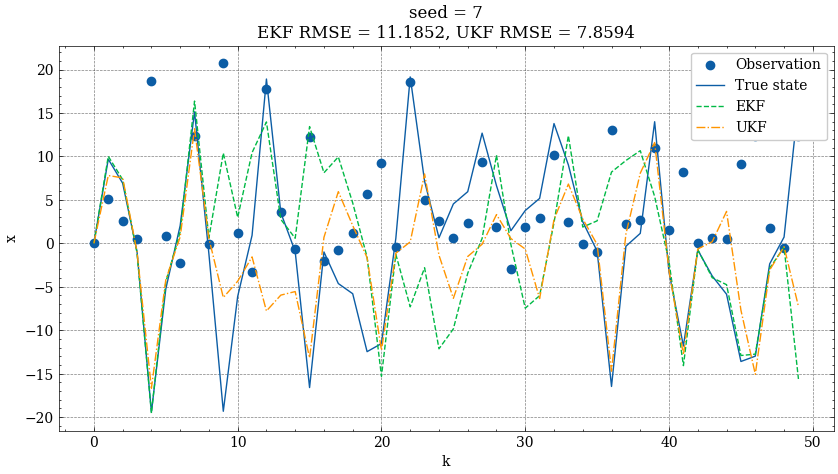

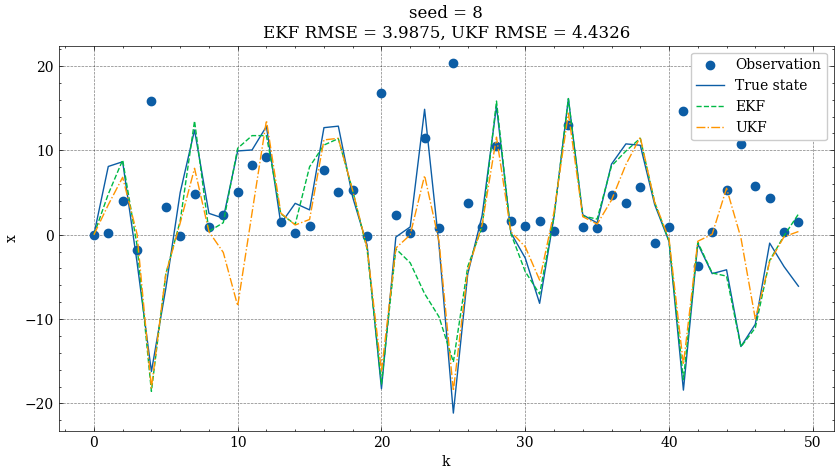

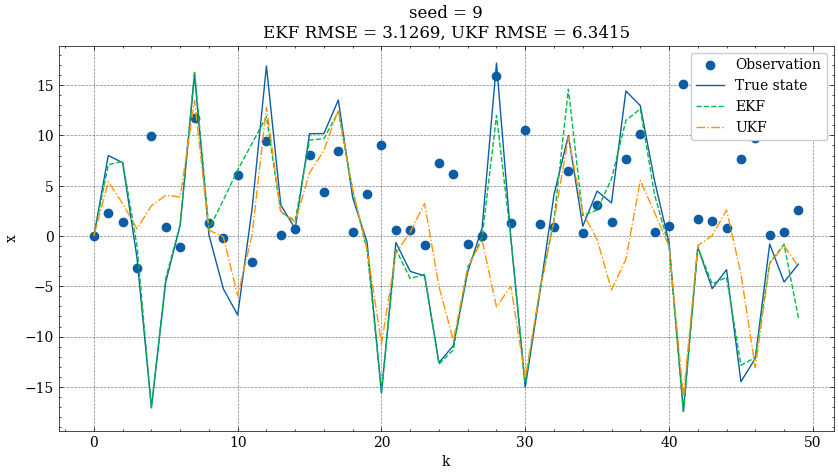

In [5]:
### シミュレーションの設定 ###
f = lambda x, k: (0.2*x + 25*x / (1+x**2) + 8*np.cos(1.2*k)) # 非線形関数
h = lambda x: (1/20 * x**2) # 非線形関数

A = lambda x: (0.2 * 25*(1-x**2)/(1+x**2)**2) # fのヤコビアン
C = lambda x: x/10 # hのヤコビアン

Q = np.array(1).reshape(-1,1) # システム雑音の共分散行列
B = np.array(1).reshape(-1,1) # システム行列
R = np.array(3).reshape(-1,1) # 観測雑音の共分散行列
N = 50 # サンプル数
n = 1 # 状態ベクトルの次元数

ekf_rmse_list = [] # EKFのRMSEを格納するリスト
ukf_rmse_list = [] # UKFのRMSEを格納するリスト

plt.figure(figsize=(20, 16))
plt.style.use(['science', 'no-latex', 'grid'])

### シミュレーションを実行 ###

for i in range(10):
    np.random.seed(i) # 乱数のシードを設定

    ### 状態ベクトルと観測ベクトルを生成 ###
    v = np.random.multivariate_normal([0], Q, N).reshape(-1,1) # システム雑音
    w = np.random.multivariate_normal([0], R, N).reshape(-1,1) # 観測雑音

    x = np.zeros([N, 1]) # 状態ベクトル
    y = np.zeros([N, 1]) # 観測ベクトル

    x[0] = 0
    y[0] = h(x[0])

    for k in range(1, N):
        x[k] = f(x[k-1], k-1) + v[k-1]
        y[k] = h(x[k]) + w[k]

    ### EKFによる推定 ###
    x_hat_ekf = np.zeros([N, 1])
    x_hat_ekf[0] = 0.0 # 初期状態推定値
    P_ekf = np.array([1.0]).reshape(-1, 1) # 初期誤差共分散行列

    for k in range(1, N):
        # EKFによる推定
        x_hat_ekf[k], P_ekf, _ = ekf(lambda x: f(x, k-1), h, A, B, C, Q, R, y[k], x_hat_ekf[k-1], P_ekf)

    ### UKFによる推定 ###
    x_hat_ukf = np.zeros([N, 1])
    x_hat_ukf[0] = 0.0 # 初期状態推定値
    P_ukf = np.matrix(np.array(1)) # 初期誤差共分散行列

    for k in range(1, N):
        x_hat_ukf[k], P_ukf, _ = ukf(lambda x: f(x, k-1), h, B, Q, R, y[k], x_hat_ukf[k-1], P_ukf)

    ### RMSEを計算 ###
    ekf_rmse = np.sqrt(np.mean(((x_hat_ekf - x)**2)))
    ukf_rmse = np.sqrt(np.mean(((x_hat_ukf - x)**2)))
    ekf_rmse_list.append(ekf_rmse)
    ukf_rmse_list.append(ukf_rmse)

    ### 結果をプロット ###
    plt.figure(figsize=(10, 5))
    plt.scatter(np.arange(N), y, label='Observation')
    plt.plot(x, label='True state', linestyle='-')
    plt.plot(x_hat_ekf, label='EKF', linestyle='--')
    plt.plot(x_hat_ukf, label='UKF', linestyle='-.')
    plt.legend(loc='upper right')
    plt.xlabel('k')
    plt.ylabel('x')
    plt.title('seed = {}\nEKF RMSE = {:.4f}, UKF RMSE = {:.4f}'.format(i, ekf_rmse, ukf_rmse))
    plt.savefig('./ekf_ukf/seed_{}.png'.format(i))


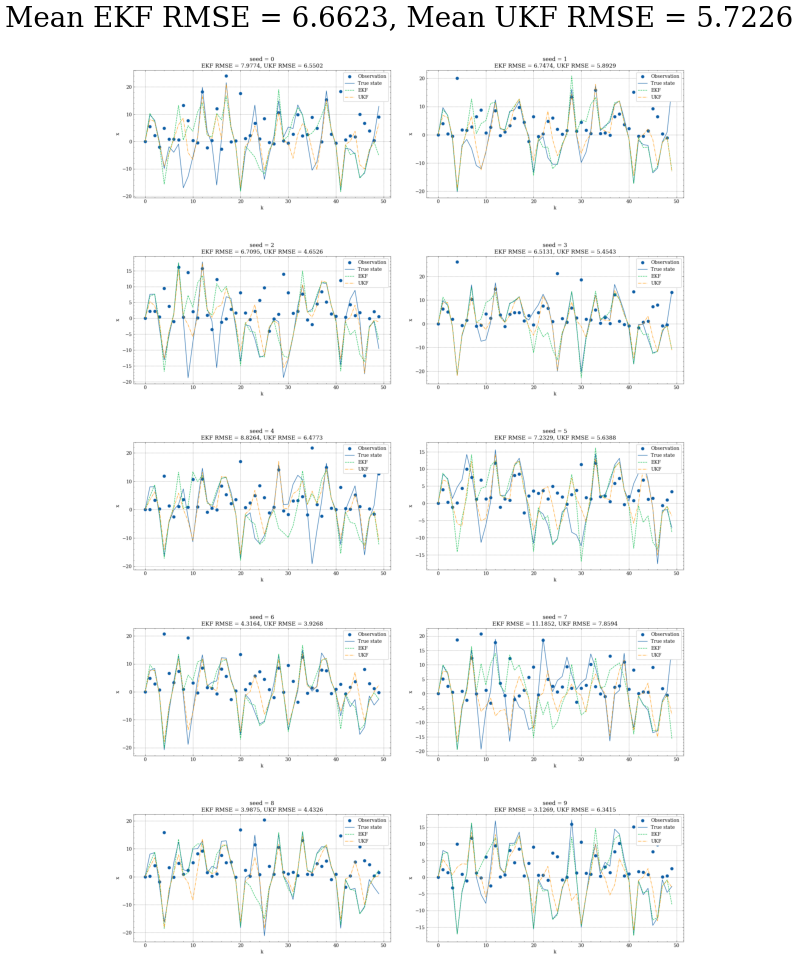

In [6]:
import os
from PIL import Image

plt.figure(figsize=(6, 10))

dir = "./ekf_ukf/"
img_list = os.listdir(dir)
imgs = []

for i in img_list:
    img = Image.open(dir + i)
    imgs.append(np.asanyarray(img))

for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')

plt.suptitle(f'Mean EKF RMSE = {np.mean(ekf_rmse_list):.4f}, Mean UKF RMSE = {np.mean(ukf_rmse_list):.4f}', fontsize=20)
plt.tight_layout()
plt.savefig('ekf_ukf.png', dpi=600)
plt.show()

In [7]:
img_path = "seed_5.png"
